# Robust Optimization Model - Bus Charging Scheduling

## Initialization

In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_excel('../Instances/input_small.xlsx', None)
EXEC_PATH = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex'

## Model definition

In [3]:
def createModel(data,gama):

    model = pyo.ConcreteModel() # create model
    
    # data
    i = len(data['Trip time']['Time begin (min)'])
    t = len(data['Energy price']['Energy buying price (per minute)'])
    k = len(data['Buses']['Bus (kWh)'])
    n = len(data['Chargers']['Charger (kWh/min)'])
    l = len(data['Power price']['Power'])
    T_start = data['Trip time']['Time begin (min)'].tolist()
    T_start = [int(x) for x in T_start]
    T_end = data['Trip time']['Time finish (min)'].tolist()
    T_end = [int(x) for x in T_end]
    alpha = data['Chargers']['Charger (kWh/min)'].tolist()
    beta = data['Chargers']['Charger (kWh/min)'].tolist()
    ch_eff = 0.90
    dch_eff = 1/0.9
    P = data['Energy price']['Energy buying price (per minute)'].tolist()
    S = data['Energy price']['Energy selling price (per minute)'].tolist()
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    E_end = 0.2
    d_off = 20
    d_on = 40
    C_bat = data['Buses']['Bus (kWh)'].tolist()
    U_pow = data['Power price']['Power'].tolist()
    U_price = data['Power price']['Price'].tolist()
    U_max = data['Chargers']['Max Power (kW)'].tolist()
    R = 130
    Ah = 905452
    V = 512
    T = t

    # sets
    model.I = pyo.RangeSet(i) # set of trips
    model.T = pyo.RangeSet(t) # set of timesteps
    model.K = pyo.RangeSet(k) # set of buses
    model.N = pyo.RangeSet(n) # set of chargers
    model.L = pyo.RangeSet(l) # set of peak power levels

    # parameters
    model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
    model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i
    model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
    model.beta = pyo.Param(model.N, initialize=lambda model, n: beta[n-1]) # discharging power of charger n
    model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
    model.dch_eff = pyo.Param(initialize=dch_eff) # discharging efficiency of charger n
    model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
    model.S = pyo.Param(model.T, initialize=lambda model, t: S[t-1]) # electricity selling price in time t
    model.gama = pyo.Param(model.I, initialize=lambda model, i: gama[i-1],mutable=True) # energy consumption
    model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
    model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
    model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
    model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
    model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1]) # total capacity of the bus k battery
    model.U_pow = pyo.Param(model.L, initialize=lambda model, l: U_pow[l-1]) # power level l
    model.U_price = pyo.Param(model.L, initialize=lambda model, l: U_price[l-1]) # purchasing price for power level l
    model.U_max = pyo.Param(initialize=U_max[0]) # contracted power
    model.R = pyo.Param(initialize=R) # battery replacement costs of the bus k
    model.Ah = pyo.Param(initialize=Ah) # energy consumed until EOL of bus k
    model.V = pyo.Param(initialize=V) # operational voltage of charger n

    # binary variables
    model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
    model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
    model.y = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to discharge
    model.c = pyo.Var(model.K, model.T, domain=pyo.Binary)  # binary variable indicating if bus k is charging/discharging at time t
    model.u = pyo.Var(model.L, domain=pyo.Binary)  # binary variable indicating the peak power level l

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity sold to the grid at time t
    model.d = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()
    #constraint 2
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.b[k,i,t] for i in model.I) + model.c[k,t] <=1)

    #constraint 3
    for i in model.I: 
        for t in range(model.T_start[i],model.T_end[i]):
            model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)

    #constraint 4
    for i in model.I:
        for k in model.K:
            for t in range(model.T_start[i],model.T_end[i]-1):
                model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])

    #constraint 5
    for n in model.N:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for k in model.K) + sum(model.y[k,n,t] for k in model.K) <= 1)

    #constraint 6
    for k in model.K:
        for t in model.T:
            model.constraints.add(sum(model.x[k,n,t] for n in model.N) + sum(model.y[k,n,t] for n in model.N) <= model.c[k,t])

    #constraint 7
    for k in model.K:
        for t in range(2,T+1):
            model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama[i]*model.b[k,i,t] for i in model.I) - sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N))

    #constraint 8.1
    for k in model.K:
        for n in model.N:
            for t in range(2,T-d_off):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1]  + ((1/d_off)*sum(model.x[k,n,j] for j in range(t,t+d_off))) <= 2) # 33

    #constraint 8.2
    for k in model.K:
        for n in model.N:
            for t in range(T-d_off+1,T):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) <= 2) # 35

    #constraint 8.3
    for k in model.K:
        for n in model.N:
            for t in range(2,T-d_on):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/d_on)*sum(model.x[k,n,j] for j in range(t,t+d_on))) >= 1) # 34

    #constraint 8.4
    for k in model.K:
        for n in model.N:
            for t in range(T-d_on+1,T):
                model.constraints.add(1 - model.x[k,n,t] + model.x[k,n,t-1] + ((1/(T-t+1))*sum(model.x[k,n,j] for j in range(t,T))) >= 1) # 36

    #constraint 9.1
    for t in model.T:
        model.constraints.add(sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])

    #constraint 9.2
    for t in model.T:
            model.constraints.add(sum(model.dch_eff*model.beta[n]*model.y[k,n,t] for n in model.N for k in model.K) == model.w_sell[t])

    #constraint 10
    model.constraints.add(sum(model.u[l] for l in model.L)==1)

    #constraint 11
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for k in model.K for n in model.N) <= sum(model.U_pow[l]*model.u[l] for l in model.L))
        
    #constraint 12
    for t in model.T:
        model.constraints.add(sum(model.alpha[n]*model.x[k,n,t] for k in model.K for n in model.N) <= model.U_max)

    #constraint 13
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)

    #constrait 14
    for k in model.K:
        for t in model.T:
            model.constraints.add(E_max * model.C_bat[k] >= model.e[k,t] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N))          

    #constraint 15.1
    for k in model.K:
        model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])

    #constraint 15.2
    for k in model.K:
        model.constraints.add(model.e[k,T-1] + sum(model.ch_eff*model.alpha[n]*model.x[k,n,T] for n in model.N) >= model.E_end*model.C_bat[k])   

    #constraint 16
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.d[k,t] == ((model.R*model.C_bat[1]*1000)/(model.Ah*model.V))* sum(model.beta[n]*model.y[k,n,t] for n in model.N))

    # objective function
    def rule_obj(mod):
        return sum(mod.P[t]*mod.w_buy[t] for t in mod.T) - sum(mod.S[t]*mod.w_sell[t] for t in mod.T) + sum(mod.d[k,t] for k in mod.K for t in mod.T) + sum(mod.U_price[l]*mod.u[l] for l in mod.L)
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.minimize)

    return model


## Instantiation / Solver

In [4]:
# energy consumption variation
def energy_consumption(data,dev,conserv):
    max_deviation = data['Energy consumption']['Maximum deviation (kWh/km*min)']
    max_deviation = max_deviation * dev * conserv
    gama = data['Energy consumption']['Uncertain energy (kWh/km*min)'] + max_deviation
    gama = gama.tolist()
    return gama

In [5]:
# creating the optimization model
gama = energy_consumption(data,0,0)
model = createModel(data,gama)

    The default domain for Param objects is 'Any'.  However, we will be
    changing that default to 'Reals' in the future.  If you really intend the
    domain of this Paramto be 'Any', you can suppress this warning by
    explicitly specifying 'within=Any' to the Param constructor. (deprecated
    in 5.6.9, will be removed in (or after) 6.0) (called from /Users/natomanzo
    lli/opt/anaconda3/envs/bus_charging_app/lib/python3.9/site-
    packages/pyomo/core/base/indexed_component.py:732)


In [6]:
# solving the problem
opt = pyo.SolverFactory('cplex',executable=EXEC_PATH)
opt.options['timelimit'] = 3600
opt.options['mipgap'] = 0.01
results = opt.solve(model,tee=False)
print(model.obj())

3.760080000000003


## Visualization

In [7]:
def visualizationData (K,T,e,w,d):
    
    # retriving energy
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)

    #retriving power
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    W = pd.DataFrame(transac_list, index=model.T, columns=['Power'])

    #retriving degradation
    degradation_list =[]
    for k in K:
        for t in T:
            degradation_list.append(pyo.value(d[k,t]))
    degradation = pd.DataFrame(degradation_list)
    return Energy, W, degradation

## Robust Optimization (Iteration)

In [8]:
def robust_formulation(devs,n):
    
    # creating column list of Γ
    column_list = []
    for i in range(n):
        column_list.append('Γ'+str(i+1))     
    
    # creating an empty Excel file
    df_devs = pd.DataFrame(devs) # creatign the excel output file
    with pd.ExcelWriter('../Results/output_robust.xlsx') as writer:
        df_devs.to_excel(writer,sheet_name='objective')
    objective = np.empty((len(devs),n))
    Energy_list = []
    Power_list = []
    Degradation_list = []
    
    # solving the problem for multiple instances
    for count, d in enumerate(devs):
        print ("\n===== iteration",count+1)
        print("deviation:",d*100,'%')
        conserv = [0] * n
        for i in range(n):
            conserv[i] = 1
            gama = energy_consumption(data,d,conserv)
            model = createModel(data,gama)
            opt.solve(model)
            print("objective function for GAMA =",conserv, " is:", model.obj())
            objective[count][i] = model.obj()
            Energy, Power, Degradation = visualizationData(model.K,model.T,model.e,model.w_buy,model.d)
            with pd.ExcelWriter('../Results/output_robust.xlsx',engine="openpyxl", mode='a',if_sheet_exists='new') as writer:
                    Energy.to_excel(writer, sheet_name='energy')
                    Power.to_excel(writer, sheet_name='power')
                    Degradation.to_excel(writer, sheet_name='degradation')
            Energy_list.append(Energy)
            Power_list.append(Power)
            Degradation_list.append(Degradation)
    Objective = pd.DataFrame(objective, columns = column_list, index=['25%','50%','75%','100%'])
    with pd.ExcelWriter('../Results/output_robust.xlsx',engine="openpyxl", mode='a',if_sheet_exists='replace') as writer:
        Objective.to_excel(writer,sheet_name='objective')
    return Objective, Energy_list, Power_list, Degradation_list

## Results

In [9]:
devs = [0.25,0.5,0.75,1] # percentage of deviation
objective, energy_list, power_list, degradation_list = robust_formulation(devs,len(data['Trip time']['Time begin (min)']))


===== iteration 1
deviation: 25.0 %
objective function for GAMA = [1, 0]  is: 3.878520000000003
objective function for GAMA = [1, 1]  is: 3.878520000000003

===== iteration 2
deviation: 50.0 %
objective function for GAMA = [1, 0]  is: 3.947400000000003
objective function for GAMA = [1, 1]  is: 3.947400000000003

===== iteration 3
deviation: 75.0 %
objective function for GAMA = [1, 0]  is: 4.0477200000000035
objective function for GAMA = [1, 1]  is: 4.0477200000000035

===== iteration 4
deviation: 100 %
objective function for GAMA = [1, 0]  is: 4.1323200000000035
objective function for GAMA = [1, 1]  is: 4.1323200000000035


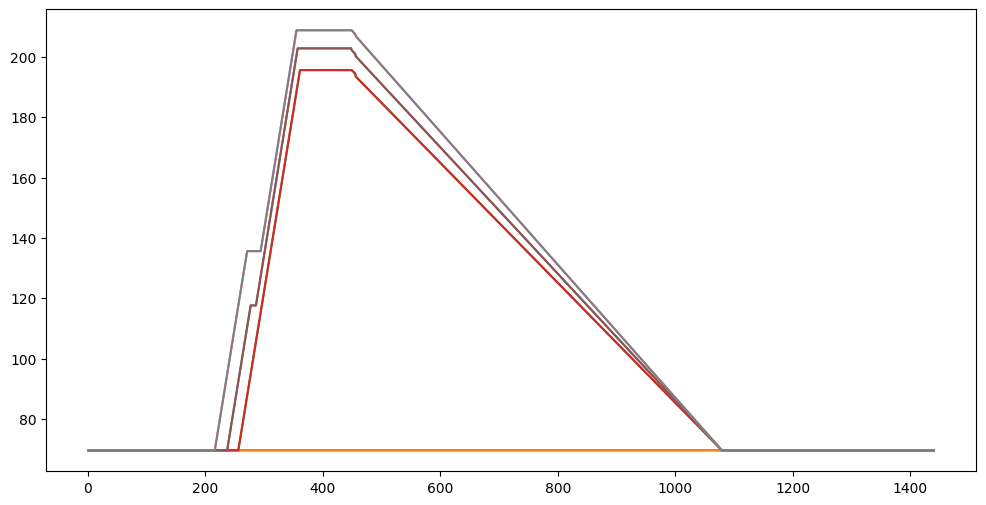

In [10]:
#Plotting energy variation -> can be done to the other variables
for i in range(len(energy_list)):
    energy_list[i]['bus 1'].plot(figsize=(12,6))

<AxesSubplot: >

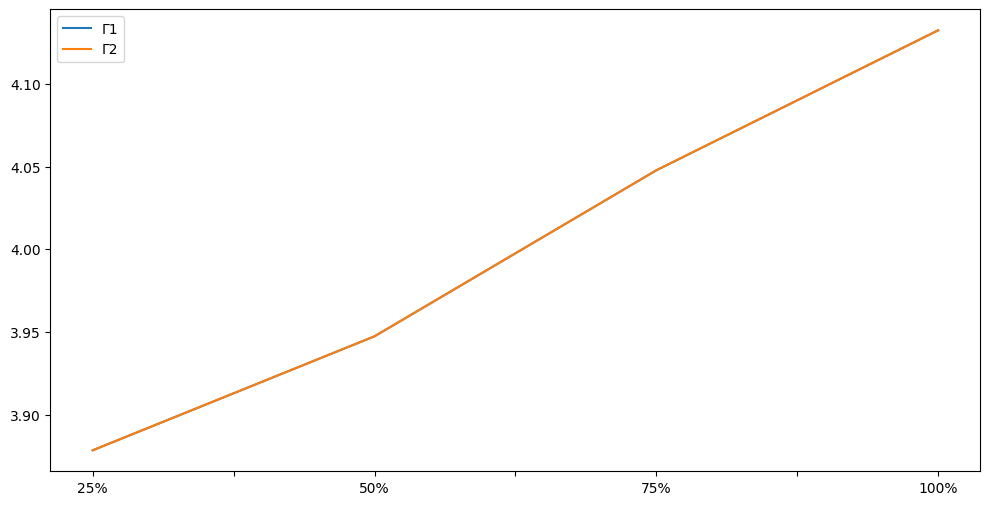

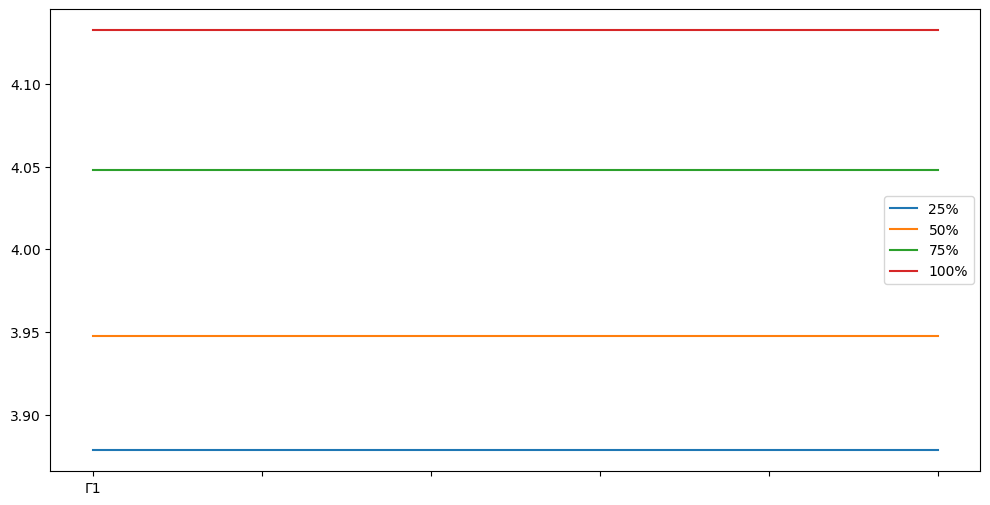

In [11]:
# Plotting Obj. function
objective.plot(figsize=(12,6))
objective.T.plot(figsize=(12,6))